### I wasn't happy with the results of my tuning functions, so i turned to this video on youtube to try something new. 
- https://www.youtube.com/watch?v=hht0iKzviWE&list=PLwzgGZH80kOUa7kMhzcMYaWPk0iFeLXon&index=21
- for this round, I'll create a model (after windorizing), then forecast, then combine dataframes. comparing mape between the two, I'll find the best set of parameters for ONLY changepoint_prior_scale and seasonality_prior_scale. I'll evaluate results from there and decide if i want to tune more parameters or look for other ways to tune. Check against other stocks as well. Following positive results, I will:
    - attempt to tune using other hyperparameters. 
    - model open, close, high, and low results for candlesticks
    - Move to '2025.01.03 To Do's' and make final changes to the UI.

In [1]:
import sys
sys.path.append("/Users/shaneypeterson/Desktop/2024.06.27_-_Data_Science/Modules")

In [2]:
import stocks as st
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly
from plotly import graph_objs as go
import streamlit
import timeit
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
from datetime import date
import itertools

In [3]:
st = st.Stocks()

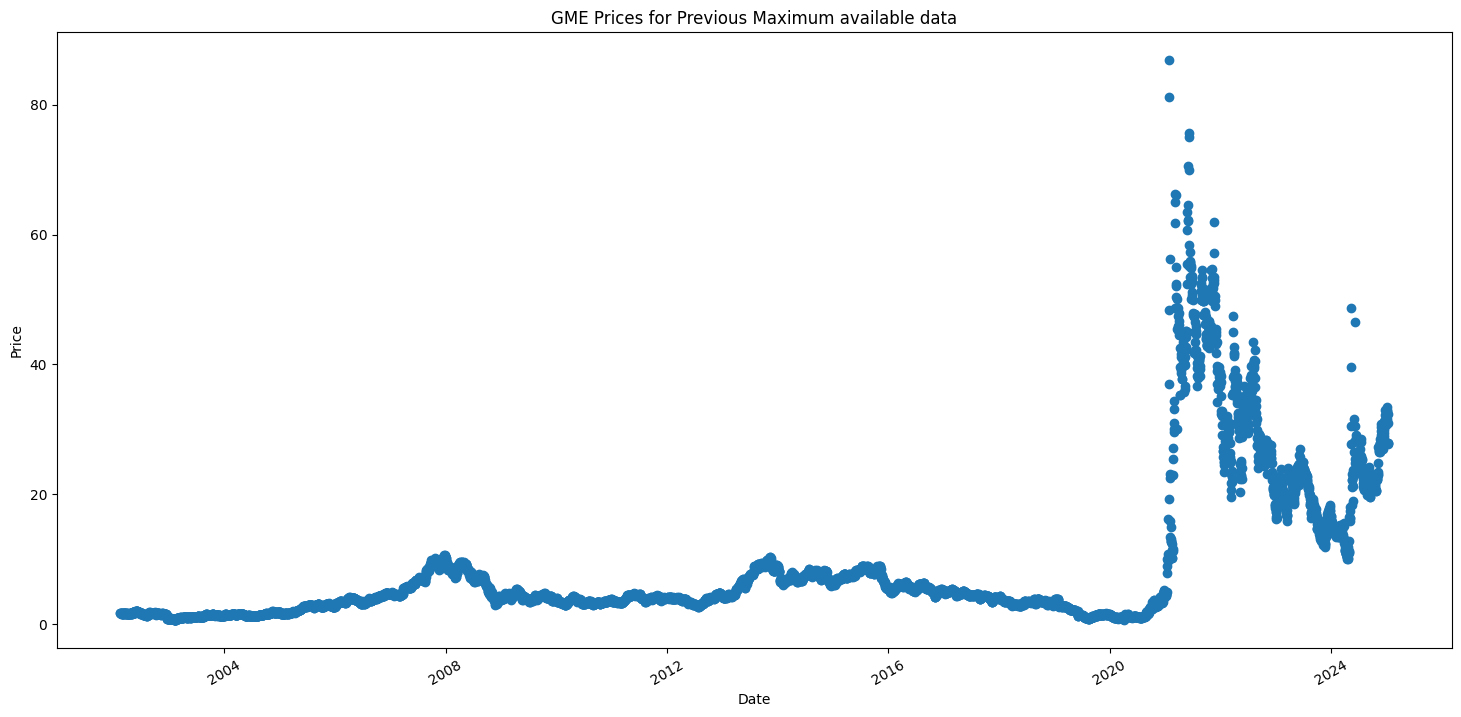

Closing price as of 2025-01-16: $27.72
The percentage change over previous Maximum available data is 1611%
Dividends total $2.39
Stock Splits total $6.0
'Capital Gains' not found in data


In [4]:
df = st.stats_generator('gme')

In [5]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-02-13 00:00:00-05:00,1.620129,1.693350,1.603296,1.691667,76216000,0.0,0.0
1,2002-02-14 00:00:00-05:00,1.712707,1.716074,1.670626,1.683250,11021600,0.0,0.0
2,2002-02-15 00:00:00-05:00,1.683250,1.687458,1.658002,1.674834,8389600,0.0,0.0
3,2002-02-19 00:00:00-05:00,1.666417,1.666417,1.578047,1.607504,7410400,0.0,0.0
4,2002-02-20 00:00:00-05:00,1.615921,1.662210,1.603296,1.662210,6892800,0.0,0.0


In [6]:
# remove timezone
import pandas as pd

df['Date'] = pd.to_datetime(df['Date']).dt.date

In [7]:
def dynamic_winsorize(df, column, window_size=30, percentiles=(0.05, 0.95)):
    """
    Winsorizes data within a rolling window.

    Args:
        df: DataFrame containing the data.
        column: Name of the column to winsorize.
        window_size: Size of the rolling window.
        percentiles: Tuple containing the lower and upper percentiles.

    Returns:
        DataFrame with the winsorized column.
    """

    df['rolling_lower'] = df[column].rolling(window=window_size).quantile(percentiles[0])
    df['rolling_upper'] = df[column].rolling(window=window_size).quantile(percentiles[1])

    df['winsorized'] = df[column]
    df.loc[df[column] < df['rolling_lower'], 'winsorized'] = df['rolling_lower']
    df.loc[df[column] > df['rolling_upper'], 'winsorized'] = df['rolling_upper']

    return df

# Apply dynamic winsorization
df = dynamic_winsorize(df, 'Close')

In [8]:
df[df['Close'] != df['winsorized']].head() # making sure dynamic_winsorize() worked

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,rolling_lower,rolling_upper,winsorized
32,2002-04-02,1.599088,1.599088,1.544382,1.568789,2098400,0.0,0.0,1.571062,1.77604,1.571062
33,2002-04-03,1.569630,1.582255,1.551956,1.565422,567200,0.0,0.0,1.566937,1.77604,1.566937
35,2002-04-05,1.594880,1.632753,1.556165,1.556165,837600,0.0,0.0,1.560331,1.77604,1.560331
36,2002-04-08,1.565423,1.565423,1.495568,1.540174,1558400,0.0,0.0,1.547370,1.77604,1.547370
40,2002-04-12,1.569631,1.569631,1.519975,1.535966,1236000,0.0,0.0,1.537859,1.77604,1.537859


In [9]:
# format new dataset for model with 'ds' and 'y' for prophet model

df_train = df[['Date' ,'Close', 'winsorized']]
df_train = df_train.rename(columns={'Date': 'ds', 'winsorized': 'y'})

In [10]:
# set training period
train_period = 365 * 4
df_train = df_train[-train_period:] 

# set forecast period
predict_period = 365

In [11]:
# create function for model accuracy

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def get_overall_accuracy(y_column, forecast):
    # Extract actual and predicted values without forecasted period
    y_true = y_column[-predict_period:]
    y_pred = forecast['yhat'][-predict_period:]

    # Calculate accuracy metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    # Create a DataFrame for the metrics
    metrics_df = pd.DataFrame({
        'Mean Absolute Error': mae,
        'Mean Absolute Percentage Error': mape,
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse
        },
        index=[0])
    
    return metrics_df

In [12]:
# create cross_validation function for reusability

cv_func = lambda model_name: cross_validation(model_name, 
                                              initial=f'{train_period} days', 
                                              period='365 days', 
                                              horizon='365 days')

In [13]:
%%time

# create baseline model

m1 = Prophet()
m1.fit(df_train)

# Get cv metrics
df_cv = cv_func(m1)
df_p = performance_metrics(df_cv)
print(pd.DataFrame(df_p.mean()).T)
period = predict_period

future = m1.make_future_dataframe(periods=period)
forecast = m1.predict(future)

get_overall_accuracy(df_train.Close, forecast)

16:30:54 - cmdstanpy - INFO - Chain [1] start processing
16:30:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

16:30:54 - cmdstanpy - INFO - Chain [1] start processing
16:30:54 - cmdstanpy - INFO - Chain [1] done processing


                       horizon         mse       rmse        mae      mape  \
0  199 days 12:22:12.158590308  180.553959  11.845064  11.493068  0.498139   

      mdape     smape  coverage  
0  0.504104  0.708618  0.334802  
CPU times: user 329 ms, sys: 71.3 ms, total: 400 ms
Wall time: 967 ms


,Mean Absolute Error,Mean Absolute Percentage Error,Mean Squared Error,Root Mean Squared Error
0,13.104747,0.803135,204.327744,14.294326


In [14]:
# # get interactive visual

# # Plot Forecast
fig1 = plot_plotly(m1, forecast)
# fig1.layout.update(title_text=f"Forecast for 1 Year: {ticker_name} '{selected_stock}'")
fig1.update_layout(yaxis_title='Price', 
                   xaxis_title='Date',
                   width=1500
                   )
# # Calculate default date range
end_date = forecast['ds'].max()
start_date = end_date - pd.Timedelta(days=1095)
fig1.update_xaxes(range=[start_date, end_date])
# fig1.update_layout(xaxis_rangeslider_visible=False)
fig1

### -- Add closing price to existing forecast for comparison --

In [15]:
df_train.ds = pd.to_datetime(df_train.ds)
df_train.ds = df_train.ds.astype('datetime64[ns]')

In [16]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [17]:
mape_df = pd.merge(left=df_train[['ds', 'Close']],
         right=forecast[['ds', 'yhat']],
         on='ds',
         how='left')

In [18]:
def calculate_mape(y_true, y_pred):
  """
  Calculates the Mean Absolute Percentage Error (MAPE) between two arrays.

  Args:
    y_true: The ground truth values.
    y_pred: The predicted values.

  Returns:
    The MAPE value.
  """
  mape = 100 * np.mean(np.abs((y_true - y_pred) / y_true))
  return mape

In [19]:
# Calculate Overall MAPE
mape_value = calculate_mape(mape_df.Close, mape_df.yhat)

print(f"MAPE: {mape_value:.2f}%")

MAPE: 53.59%


### -- Investigate MAPE Extremes --

In [20]:
df_p.sort_values('mape', ascending=False).head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
226,365 days,790.802934,28.121219,27.981028,0.923718,0.924864,1.725199,0.0
225,364 days,783.541374,27.991809,27.836831,0.918262,0.919271,1.706923,0.0
224,363 days,776.766866,27.870538,27.704845,0.912241,0.907961,1.686866,0.0
223,362 days,768.904751,27.729132,27.550192,0.905812,0.904010,1.665470,0.0
222,359 days,750.273245,27.391116,27.194081,0.898464,0.883339,1.641232,0.0


In [21]:
df_cv['mape'] = np.abs((df_cv['y'] - df_cv['yhat']) / df_cv['y'])

In [22]:
view_mape_df_cv = df_cv[['ds', 'yhat', 'mape']]

In [23]:
with pd.option_context('display.max_rows', None):
    print(view_mape_df_cv.sort_values('mape', ascending=False))

            ds       yhat      mape
247 2025-01-13   0.408902  0.986818
246 2025-01-10   0.437487  0.986460
245 2025-01-08   0.490355  0.985123
244 2025-01-07   0.543164  0.983497
243 2025-01-06   0.595244  0.981708
248 2025-01-14   0.528338  0.981050
249 2025-01-15   0.646346  0.976883
250 2025-01-16   0.738344  0.973364
242 2025-01-03   1.106091  0.965052
241 2025-01-02   1.224085  0.960076
240 2024-12-31   1.582792  0.949496
239 2024-12-30   1.724014  0.946141
238 2024-12-27   2.387608  0.924864
237 2024-12-26   2.519243  0.919271
236 2024-12-24   2.856156  0.907961
235 2024-12-23   2.965656  0.904010
234 2024-12-20   3.478836  0.883339
233 2024-12-19   3.550595  0.877566
231 2024-12-17   3.768813  0.876989
232 2024-12-18   3.685466  0.870912
230 2024-12-16   3.824296  0.870099
228 2024-12-12   4.272307  0.851398
229 2024-12-13   4.220188  0.849225
227 2024-12-11   4.398547  0.848169
225 2024-12-09   4.553287  0.836975
226 2024-12-10   4.484413  0.833479
224 2024-12-06   5.045984  0

- By looking at the date of the highest and lowest MAPE, we can see that the model performs the best around March / April and worst in January
- There's a huge blip in the data in January 2021 that is probably throwing the data off during that time. 
- I adjusted the the winsor function to fit a little tighter - boundaries were set at 0.05% and 0.95% and now they are 0.15% and 0.85%. 
    - MAPE went from 54% to 51%

### -- Hypertuning --

In [24]:
%%time

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# Generate combos of all pararmeters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

for params in all_params:
    m = Prophet(**params).fit(df_train)
    df_cv = cross_validation(m, 
                             initial=f'{train_period} days', 
                             period='365 days', 
                             horizon='365 days',
                             parallel='processes'
                             )
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

    # Find best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

16:30:55 - cmdstanpy - INFO - Chain [1] start processing
16:30:55 - cmdstanpy - INFO - Chain [1] done processing
16:30:56 - cmdstanpy - INFO - Chain [1] start processing
16:30:56 - cmdstanpy - INFO - Chain [1] done processing
16:30:56 - cmdstanpy - INFO - Chain [1] start processing
16:30:56 - cmdstanpy - INFO - Chain [1] done processing
16:30:56 - cmdstanpy - INFO - Chain [1] start processing
16:30:56 - cmdstanpy - INFO - Chain [1] done processing
16:30:56 - cmdstanpy - INFO - Chain [1] start processing
16:30:56 - cmdstanpy - INFO - Chain [1] done processing
16:30:57 - cmdstanpy - INFO - Chain [1] start processing
16:30:57 - cmdstanpy - INFO - Chain [1] done processing
16:30:57 - cmdstanpy - INFO - Chain [1] start processing
16:30:57 - cmdstanpy - INFO - Chain [1] done processing
16:30:58 - cmdstanpy - INFO - Chain [1] start processing
16:30:58 - cmdstanpy - INFO - Chain [1] done processing
16:30:58 - cmdstanpy - INFO - Chain [1] start processing
16:30:58 - cmdstanpy - INFO - Chain [1]

CPU times: user 1.16 s, sys: 327 ms, total: 1.48 s
Wall time: 15.7 s


16:31:11 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
tuning_results.sort_values('rmse')

,changepoint_prior_scale,seasonality_prior_scale,rmse
13,0.500,0.10,11.450522
14,0.500,1.00,11.460526
15,0.500,10.00,11.585387
12,0.500,0.01,11.661314
1,0.001,0.10,12.183529
0,0.001,0.01,12.253853
8,0.100,0.01,14.027697
11,0.100,10.00,14.046226
10,0.100,1.00,14.063870
2,0.001,1.00,14.114923


In [26]:
best_params_dict = dict(tuning_results.sort_values('rmse').reset_index(drop=True).drop('rmse', axis='columns').iloc[0])
best_params_dict

{'changepoint_prior_scale': np.float64(0.5),
 'seasonality_prior_scale': np.float64(0.1)}

In [27]:
%%time

# create revised model

m2 = Prophet(**best_params_dict)
m2.fit(df_train)

# Get cv metrics
df_cv = cv_func(m2)
df_p = performance_metrics(df_cv)
print(pd.DataFrame(df_p.mean()).T)
period = predict_period

future = m2.make_future_dataframe(periods=period)
forecast = m2.predict(future)

get_overall_accuracy(df_train.Close, forecast)

16:31:11 - cmdstanpy - INFO - Chain [1] start processing
16:31:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

16:31:11 - cmdstanpy - INFO - Chain [1] start processing
16:31:12 - cmdstanpy - INFO - Chain [1] done processing


                       horizon         mse      rmse       mae      mape  \
0  199 days 12:22:12.158590308  113.354514  9.434672  9.084928  0.405636   

      mdape     smape  coverage  
0  0.406201  0.509524  0.977974  
CPU times: user 321 ms, sys: 60 ms, total: 381 ms
Wall time: 1.1 s


,Mean Absolute Error,Mean Absolute Percentage Error,Mean Squared Error,Root Mean Squared Error
0,14.763975,0.8819,245.265544,15.660956


In [28]:
mape_df = pd.merge(left=df_train[['ds', 'Close']],
         right=forecast[['ds', 'yhat']],
         on='ds',
         how='left')

In [29]:
# Calculate Overall MAPE
mape_value = calculate_mape(mape_df.Close, mape_df.yhat)

print(f"MAPE: {mape_value:.2f}%")

MAPE: 39.95%


In [30]:
# # get interactive visual

# # Plot Forecast
fig = plot_plotly(m2, forecast)
fig.update_layout(yaxis_title='Price', 
                   xaxis_title='Date',
                   width=1500
                   )
# # Calculate default date range
end_date = forecast['ds'].max()
start_date = end_date - pd.Timedelta(days=1095)
fig.update_xaxes(range=[start_date, end_date])
fig

In [31]:
# indicators 

import ta

def add_indicators(data):
    data['SMA50'] = data['Close'].rolling(window=50).mean()
    indicator_bb = ta.volatility.BollingerBands(close=data['Close'], window=20, window_dev=2)
    data['bb_upper'] = indicator_bb.bollinger_hband()
    data['bb_lower'] = indicator_bb.bollinger_lband()
    return data

In [32]:
df.head(1)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,rolling_lower,rolling_upper,winsorized
0,2002-02-13,1.620129,1.69335,1.603296,1.691667,76216000,0.0,0.0,NaN,NaN,1.691667


In [33]:
df = add_indicators(df)

In [34]:
df.head(1)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,rolling_lower,rolling_upper,winsorized,SMA50,bb_upper,bb_lower
0,2002-02-13,1.620129,1.69335,1.603296,1.691667,76216000,0.0,0.0,NaN,NaN,1.691667,NaN,NaN,NaN


In [35]:
# candlestick func
def plot_raw_data(data):
    fig = go.Figure()

    # Add candlestick trace
    fig.add_trace(go.Candlestick(x=data['Date'],
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'],
                name='Candlestick'))


    # Add SMA trace
    fig.add_trace(go.Scatter(x=data['Date'], 
                            y=data['SMA50'], 
                            name='SMA50', 
                            line=dict(color='black', width=2, dash='dash'),
                            visible='legendonly'))

    # Add upper Bollinger Band
    fig.add_trace(go.Scatter(x=data['Date'], 
                             y=data['bb_upper'], 
                             line=dict(color='red', width=1), 
                             name='Upper BB',
                             visible='legendonly'))
    
    # Add lower Bollinger Band
    fig.add_trace(go.Scatter(x=data['Date'], 
                             y=data['bb_lower'], 
                             line=dict(color='green', width=1), 
                             name='Lower BB',
                             visible='legendonly'))
    


    # Labels
    fig.layout.update(
        # title_text=f"Time Series Data: {ticker_name} '{selected_stock}'",
                xaxis_rangeslider_visible=True,
                yaxis_title='Price',
                xaxis_title='Date')
    
    # Calculate default date range
    end_date = data['Date'].max()
    start_date = end_date - pd.Timedelta(days=365)
    fig.update_xaxes(range=[start_date, end_date])

    fig.show()

In [36]:
plot_raw_data(df)

- combine forecast and OG trend into new df. this df will feed into the candlestick chart.

In [37]:
df.Date = pd.to_datetime(df.Date)
df.Date = df.Date.astype('datetime64[ns]')

In [53]:
forecast_candlestick_df = pd.merge(
    left=df,
    right=forecast,
    right_on='ds',
    left_on='Date',
    how='right')[['ds', 'Open', 'High', 'Low', 'Close', 'yhat', 'yhat_lower', 'yhat_upper', 'SMA50', 'bb_upper', 'bb_lower']]
forecast_candlestick_df.rename(columns={'ds': 'Date'}, inplace=True) # keep naming convention
forecast_candlestick_df

,Date,Open,High,Low,Close,yhat,yhat_lower,yhat_upper,SMA50,bb_upper,bb_lower
0,2019-03-29,2.5525,2.5900,2.5375,2.5400,4.381488,-0.865205,9.876668,2.877170,2.885989,2.495614
1,2019-04-01,2.5725,2.6050,2.5100,2.5925,3.703149,-2.236426,9.128437,2.852758,2.873757,2.487338
2,2019-04-02,2.5925,2.6025,2.5225,2.5250,3.514019,-1.588164,9.273848,2.826222,2.862250,2.470862
3,2019-04-03,2.2150,2.5075,2.2050,2.4075,3.295318,-2.192970,8.981602,2.800527,2.863753,2.430592
4,2019-04-04,2.4350,2.5150,2.4125,2.5075,3.101387,-2.294840,8.563368,2.775817,2.844839,2.420014
...,...,...,...,...,...,...,...,...,...,...,...
1820,2026-01-12,NaN,NaN,NaN,NaN,38.222420,-3.236269,74.328221,NaN,NaN,NaN
1821,2026-01-13,NaN,NaN,NaN,NaN,38.284626,-2.229447,76.547700,NaN,NaN,NaN
1822,2026-01-14,NaN,NaN,NaN,NaN,38.328449,-4.138358,76.216906,NaN,NaN,NaN
1823,2026-01-15,NaN,NaN,NaN,NaN,38.405511,-2.318069,76.360952,NaN,NaN,NaN


In [49]:
# candlestick func

def plot_forecast(data):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=data['Date'], 
                         y=data['yhat_lower'], 
                         line=dict(color='lightblue', width=2), 
                         name='Forecast Lower Bound'))
    
    # Add upper forecast bound (yhat_upper)
    fig.add_trace(go.Scatter(x=data['Date'], 
                             y=data['yhat_upper'], 
                             line=dict(color='lightblue', width=2), 
                             name='Forecast Upper Bound',
                             fill='tonextx', # Fill between forecast and upper bound
                             fillcolor=None,
                             opacity=0.01))

    # Add forecast line (yhat)
    fig.add_trace(go.Scatter(x=data['Date'], 
                             y=data['yhat'], 
                             line=dict(color='blue', width=2), 
                             name='Forecast',
                             mode='lines'))

    # Add upper Bollinger Band
    fig.add_trace(go.Scatter(x=data['Date'], 
                             y=data['bb_upper'], 
                             line=dict(color='red', width=1), 
                             name='Upper BB',
                             visible='legendonly'))
    
    # Add lower Bollinger Band
    fig.add_trace(go.Scatter(x=data['Date'], 
                             y=data['bb_lower'], 
                             line=dict(color='green', width=1), 
                             name='Lower BB',
                             visible='legendonly'))
    
    # Add SMA trace
    fig.add_trace(go.Scatter(x=data['Date'], 
                            y=data['SMA50'], 
                            name='SMA50', 
                            line=dict(color='black', width=2, dash='dash'),
                            visible='legendonly'))

    # Add candlestick trace
    fig.add_trace(go.Candlestick(x=data['Date'],
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'],
                name='Candlestick'))

    # Labels
    fig.layout.update(
        # title_text=f"Time Series Data: {ticker_name} '{selected_stock}'",
                xaxis_rangeslider_visible=True,
                yaxis_title='Price',
                xaxis_title='Date')
    
    # Calculate default date range
    end_date = data['Date'].max()
    start_date = end_date - pd.Timedelta(days=365*3)
    fig.update_xaxes(range=[start_date, end_date])

    fig.show()

In [50]:
plot_raw_data(forecast_candlestick_df)

In [54]:
forecast_candlestick_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'yhat', 'yhat_lower',
       'yhat_upper', 'SMA50', 'bb_upper', 'bb_lower'],
      dtype='object')